In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [34]:
import pandas as pd
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from src.utils.metrics import event_detection_ap

from src.utils.post_process import post_process_for_seg
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

plt.style.use("ggplot")

EXP_NAME = "exp002"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix(), version_base="1.2")
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [35]:
cfg = load_config(RESULT_DIR)
preds = np.load(RESULT_DIR / "preds.npy")
labels = np.load(RESULT_DIR / "labels.npy")
keys = np.load(RESULT_DIR / "keys.npy")

# gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = pd.read_csv("/home/abcd/practice/kaggle/cmi2/kaggle-child-mind-institute-detect-sleep-states/data/train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

In [36]:
labels.shape, preds.shape

((2407, 5760, 2), (2407, 5760, 2))

In [61]:
# TODO: debug 为啥score差距这么大，应该是什么地方算错了
pred_df: pl.DataFrame = post_process_for_seg(
    keys, preds[:, :, [0, 1]], score_th=0.005, distance=88
)
score = event_detection_ap(gt_df, pred_df.to_pandas())
score

0.002476288561587232

In [56]:
pred_df.to_pandas().query('series_id=="89bd631d1769"')

,row_id,series_id,step,event,score
3441,3441,89bd631d1769,3707,onset,0.674805
3442,3442,89bd631d1769,3807,onset,0.176880
3443,3443,89bd631d1769,5790,wakeup,0.025833
3444,3444,89bd631d1769,11520,onset,0.012970
3445,3445,89bd631d1769,14760,wakeup,0.641113
...,...,...,...,...,...
3630,3630,89bd631d1769,212836,onset,0.399414
3631,3631,89bd631d1769,212879,wakeup,0.015900
3632,3632,89bd631d1769,212980,wakeup,0.012383
3633,3633,89bd631d1769,212984,onset,0.193726


In [59]:
gt_df.query('series_id=="89bd631d1769"').head()

,series_id,night,event,step,timestamp
934,89bd631d1769,1,onset,3684.0,2018-01-16T22:07:00-0500
935,89bd631d1769,1,wakeup,7152.0,2018-01-17T02:56:00-0500
936,89bd631d1769,2,onset,20880.0,2018-01-17T22:00:00-0500
937,89bd631d1769,2,wakeup,26280.0,2018-01-18T05:30:00-0500
938,89bd631d1769,3,onset,38340.0,2018-01-18T22:15:00-0500


In [53]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)
    print(len(unique_series_ids))

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)
    print(random_series_ids)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 2)
        this_series_labels = labels[series_idx].reshape(-1, 2)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 0])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_wakeup")
            # axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="r")
            axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="b")
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

56
['89bd631d1769']


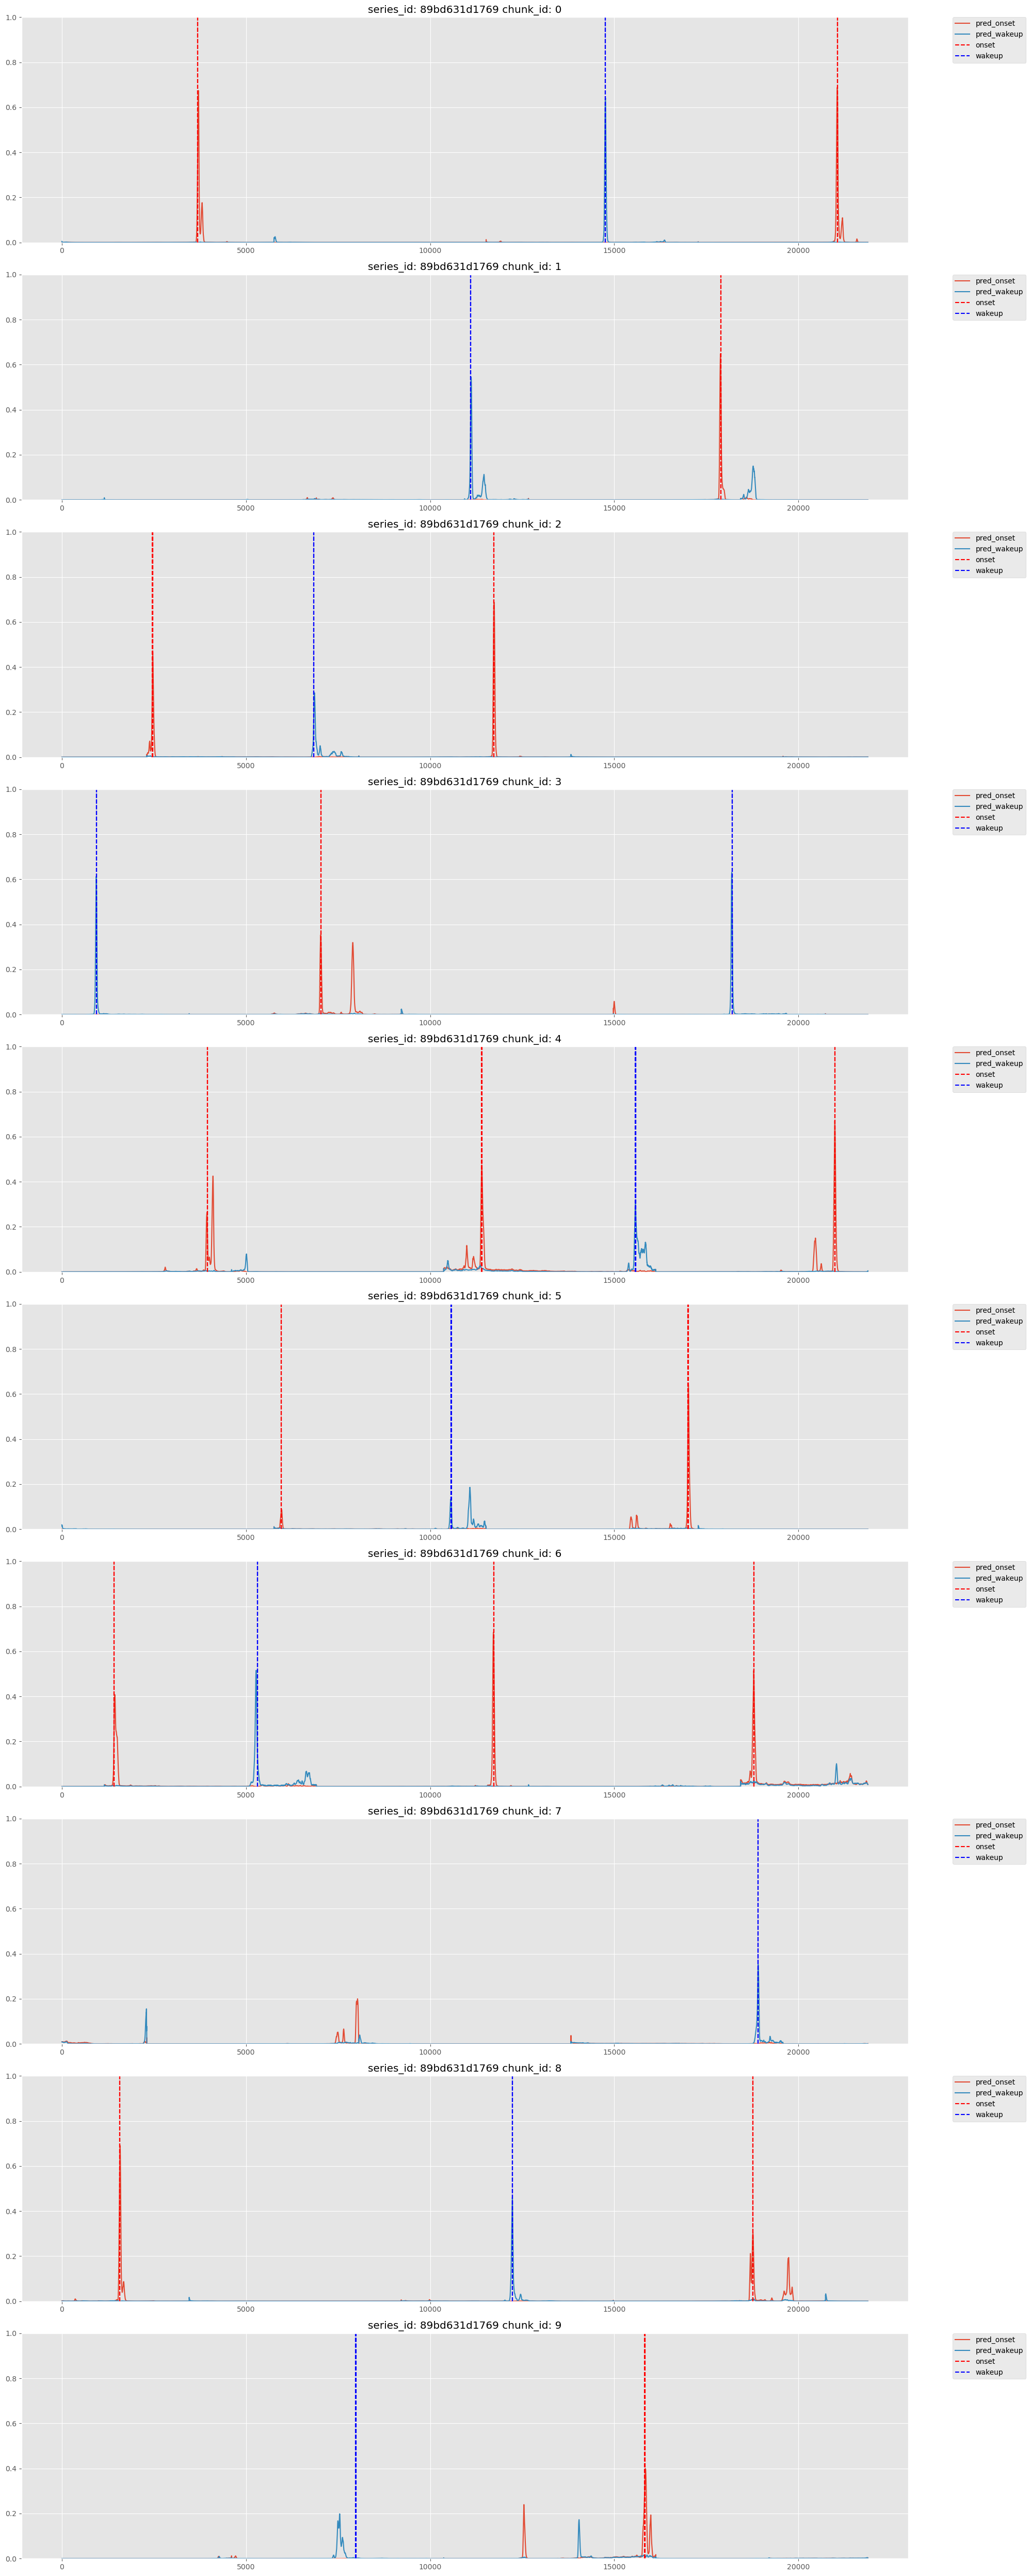

In [54]:
plot_random_sample(keys, preds, labels, num_chunks=10)